References:
* https://www.kaggle.com/kulkarnivishwanath/ashrae-great-energy-predictor-iii-eda-model
* https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import random
import math
import psutil
import pickle

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [3]:
%%time
root = '../input/ashrae-energy-prediction/'
train = pd.read_csv(root + 'train.csv', parse_dates=['timestamp'])
weather_train = pd.read_csv(root + 'weather_train.csv', parse_dates=['timestamp'])
test = pd.read_csv(root + 'test.csv', parse_dates=['timestamp'], usecols=['building_id','meter','timestamp'])
weather_test = pd.read_csv(root + 'weather_test.csv', parse_dates=['timestamp'])
metadata = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 48.9 s, sys: 6.89 s, total: 55.7 s
Wall time: 55.9 s


In [4]:
print('Size of train data', train.shape)
print('Size of test data', train.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_meta data', metadata.shape)

Size of train data (20216100, 4)
Size of test data (20216100, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building_meta data (1449, 6)


In [5]:
train['meter_reading'] = np.log1p(train['meter_reading'])

In [6]:
# Dropping floor_count variable as it has 75% missing values
metadata.drop('floor_count',axis=1,inplace=True)

In [7]:
metadata['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [8]:
metadata['primary_use'].replace({"Healthcare":"Other","Parking":"Other","Warehouse/storage":"Other","Manufacturing/industrial":"Other",
                                "Retail":"Other","Services":"Other","Technology/science":"Other","Food sales and service":"Other",
                                "Utility":"Other","Religious worship":"Other"},inplace=True)


In [9]:
metadata['square_feet'] = np.log1p(metadata['square_feet'])

In [10]:
np.mean(metadata['year_built'].astype(np.float32))

1967.95703125

In [11]:
# metadata['year_built'].fillna(1968, inplace=True)
metadata['year_built'].fillna(-999, inplace=True)
metadata['year_built'] = metadata['year_built'].astype('int16')
# metadata['year_built'] = metadata['year_built'] - metadata['year_built'].min()

In [12]:
metadata.isna().sum()/len(metadata)

site_id        0.0
building_id    0.0
primary_use    0.0
square_feet    0.0
year_built     0.0
dtype: float64

In [13]:
weather_train.isna().sum()/len(weather_train)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

In [14]:
weather_train[weather_train['cloud_coverage'].isnull()]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
5,0,2016-01-01 05:00:00,19.4,NaN,19.4,0.0,NaN,0.0,0.0
7,0,2016-01-01 07:00:00,21.1,NaN,21.1,0.0,1018.8,210.0,1.5
8,0,2016-01-01 08:00:00,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
9,0,2016-01-01 09:00:00,21.1,NaN,20.6,0.0,1019.0,290.0,1.5
...,...,...,...,...,...,...,...,...,...
139767,15,2016-12-31 18:00:00,2.8,NaN,-7.8,NaN,1007.7,180.0,8.2
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [15]:
weather_train.groupby(['site_id'])['cloud_coverage'].mean()

site_id
0     3.044610
1     0.084656
2     1.958469
3     3.879136
4     1.867999
5     0.290642
6     0.647668
7          NaN
8     3.044610
9     0.610673
10    0.376500
11         NaN
12    5.723091
13    2.873133
14    0.562203
15    1.109988
Name: cloud_coverage, dtype: float64

In [16]:
#Fill null values with mean value from each site
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
weather_train = weather_train.set_index(['site_id'])
weather_test = weather_test.set_index(['site_id'])
for col in cols:
    weather_train[col].fillna(weather_train.groupby(['site_id'])[col].mean(),inplace=True)
    weather_test[col].fillna(weather_test[col].mean(),inplace=True)
    
weather_train = weather_train.reset_index()
weather_test = weather_test.reset_index()

In [17]:
weather_train[weather_train['cloud_coverage'].isnull()]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
61430,7,2016-01-01 00:00:00,-1.8,NaN,-3.2,11.350205,1016.0,280.0,1.5
61431,7,2016-01-01 01:00:00,-1.7,NaN,-2.8,11.350205,1016.1,260.0,1.0
61432,7,2016-01-01 02:00:00,-2.7,NaN,-3.3,11.350205,1015.8,350.0,0.5
61433,7,2016-01-01 03:00:00,-2.3,NaN,-3.2,11.350205,1015.4,280.0,1.5
61434,7,2016-01-01 04:00:00,-2.6,NaN,-3.3,11.350205,1015.1,310.0,2.1
...,...,...,...,...,...,...,...,...,...
104999,11,2016-12-31 19:00:00,-10.3,NaN,-11.9,2.000000,1007.2,70.0,5.1
105000,11,2016-12-31 20:00:00,-9.9,NaN,-11.5,2.000000,1006.3,70.0,5.7
105001,11,2016-12-31 21:00:00,-9.9,NaN,-11.5,11.350205,1005.8,70.0,5.1
105002,11,2016-12-31 22:00:00,-9.8,NaN,-11.1,3.000000,1005.3,60.0,5.1


In [18]:
#As there are still null values (for sites where data is totally missing)
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    weather_train[col].fillna(-999, inplace=True)
    weather_test[col].fillna(-999, inplace=True)

In [19]:
## Function to reduce the DF size, from: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
metadata = reduce_mem_usage(metadata)

Mem. usage decreased to 250.63 Mb (59.4% reduction)
Mem. usage decreased to 437.43 Mb (54.2% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.02 Mb (55.7% reduction)


In [21]:
%%time
train = pd.merge(train,metadata,on='building_id',how='left')
test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data+Metadata Shape {}".format(train.shape))
print ("Testing Data+Metadata Shape {}".format(test.shape))
gc.collect()
train = pd.merge(train,weather_train,on=['site_id','timestamp'],how='left')
test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data+Metadata+Weather Shape {}".format(train.shape))
print ("Testing Data+Metadata+Weather Shape {}".format(test.shape))
gc.collect()

Training Data+Metadata Shape (20216100, 8)
Testing Data+Metadata Shape (41697600, 7)
Training Data+Metadata+Weather Shape (20216100, 15)
Testing Data+Metadata+Weather Shape (41697600, 14)
CPU times: user 19.3 s, sys: 8.67 s, total: 27.9 s
Wall time: 27.9 s


0

In [22]:
for df in [train, test]:
    df['Month'] = df['timestamp'].dt.month.astype("uint8")
    df['DayOfMonth'] = df['timestamp'].dt.day.astype("uint8")
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['Hour'] = df['timestamp'].dt.hour.astype("uint8")

In [23]:
# Drop nonsense entries
# As per the discussion in the following thread, https://www.kaggle.com/c/ashrae-energy-prediction/discussion/117083, there is some discrepancy in the meter_readings for different ste_id's and buildings. It makes sense to delete them
idx_to_drop = list((train[(train['site_id'] == 0) & (train['timestamp'] < "2016-05-21 00:00:00")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

# dropping all the electricity meter readings that are 0, after considering them as anomalies.
idx_to_drop = list(train[(train['meter'] == 0) & (train['meter_reading'] == 0)].index)
print(len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

392857
185592


In [24]:
%%time
number_unique_meter_per_building = train.groupby('building_id')['meter'].nunique()
train['number_unique_meter_per_building'] = train['building_id'].map(number_unique_meter_per_building)


mean_meter_reading_per_building = train.groupby('building_id')['meter_reading'].mean()
train['mean_meter_reading_per_building'] = train['building_id'].map(mean_meter_reading_per_building)
median_meter_reading_per_building = train.groupby('building_id')['meter_reading'].median()
train['median_meter_reading_per_building'] = train['building_id'].map(median_meter_reading_per_building)
std_meter_reading_per_building = train.groupby('building_id')['meter_reading'].std()
train['std_meter_reading_per_building'] = train['building_id'].map(std_meter_reading_per_building)


mean_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].mean()
train['mean_meter_reading_on_year_built'] = train['year_built'].map(mean_meter_reading_on_year_built)
median_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].median()
train['median_meter_reading_on_year_built'] = train['year_built'].map(median_meter_reading_on_year_built)
std_meter_reading_on_year_built = train.groupby('year_built')['meter_reading'].std()
train['std_meter_reading_on_year_built'] = train['year_built'].map(std_meter_reading_on_year_built)


mean_meter_reading_per_meter = train.groupby('meter')['meter_reading'].mean()
train['mean_meter_reading_per_meter'] = train['meter'].map(mean_meter_reading_per_meter)
median_meter_reading_per_meter = train.groupby('meter')['meter_reading'].median()
train['median_meter_reading_per_meter'] = train['meter'].map(median_meter_reading_per_meter)
std_meter_reading_per_meter = train.groupby('meter')['meter_reading'].std()
train['std_meter_reading_per_meter'] = train['meter'].map(std_meter_reading_per_meter)


mean_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].mean()
train['mean_meter_reading_per_primary_usage'] = train['primary_use'].map(mean_meter_reading_per_primary_usage)
median_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].median()
train['median_meter_reading_per_primary_usage'] = train['primary_use'].map(median_meter_reading_per_primary_usage)
std_meter_reading_per_primary_usage = train.groupby('primary_use')['meter_reading'].std()
train['std_meter_reading_per_primary_usage'] = train['primary_use'].map(std_meter_reading_per_primary_usage)


mean_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].mean()
train['mean_meter_reading_per_site_id'] = train['site_id'].map(mean_meter_reading_per_site_id)
median_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].median()
train['median_meter_reading_per_site_id'] = train['site_id'].map(median_meter_reading_per_site_id)
std_meter_reading_per_site_id = train.groupby('site_id')['meter_reading'].std()
train['std_meter_reading_per_site_id'] = train['site_id'].map(std_meter_reading_per_site_id)


test['number_unique_meter_per_building'] = test['building_id'].map(number_unique_meter_per_building)

test['mean_meter_reading_per_building'] = test['building_id'].map(mean_meter_reading_per_building)
test['median_meter_reading_per_building'] = test['building_id'].map(median_meter_reading_per_building)
test['std_meter_reading_per_building'] = test['building_id'].map(std_meter_reading_per_building)

test['mean_meter_reading_on_year_built'] = test['year_built'].map(mean_meter_reading_on_year_built)
test['median_meter_reading_on_year_built'] = test['year_built'].map(median_meter_reading_on_year_built)
test['std_meter_reading_on_year_built'] = test['year_built'].map(std_meter_reading_on_year_built)

test['mean_meter_reading_per_meter'] = test['meter'].map(mean_meter_reading_per_meter)
test['median_meter_reading_per_meter'] = test['meter'].map(median_meter_reading_per_meter)
test['std_meter_reading_per_meter'] = test['meter'].map(std_meter_reading_per_meter)

test['mean_meter_reading_per_primary_usage'] = test['primary_use'].map(mean_meter_reading_per_primary_usage)
test['median_meter_reading_per_primary_usage'] = test['primary_use'].map(median_meter_reading_per_primary_usage)
test['std_meter_reading_per_primary_usage'] = test['primary_use'].map(std_meter_reading_per_primary_usage)

test['mean_meter_reading_per_site_id'] = test['site_id'].map(mean_meter_reading_per_site_id)
test['median_meter_reading_per_site_id'] = test['site_id'].map(median_meter_reading_per_site_id)
test['std_meter_reading_per_site_id'] = test['site_id'].map(std_meter_reading_per_site_id)

CPU times: user 48.3 s, sys: 11.9 s, total: 1min
Wall time: 1min


In [25]:
%%time
for df in [train, test]:
    df['mean_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['median_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['std_meter_reading_per_building'] = df['std_meter_reading_per_building'].astype("float16")
    
    df['mean_meter_reading_on_year_built'] = df['mean_meter_reading_on_year_built'].astype("float16")
    df['median_meter_reading_on_year_built'] = df['median_meter_reading_on_year_built'].astype("float16")
    df['std_meter_reading_on_year_built'] = df['std_meter_reading_on_year_built'].astype("float16")
    
    df['mean_meter_reading_per_meter'] = df['mean_meter_reading_per_meter'].astype("float16")
    df['median_meter_reading_per_meter'] = df['median_meter_reading_per_meter'].astype("float16")
    df['std_meter_reading_per_meter'] = df['std_meter_reading_per_meter'].astype("float16")
    
    df['mean_meter_reading_per_primary_usage'] = df['mean_meter_reading_per_primary_usage'].astype("float16")
    df['median_meter_reading_per_primary_usage'] = df['median_meter_reading_per_primary_usage'].astype("float16")
    df['std_meter_reading_per_primary_usage'] = df['std_meter_reading_per_primary_usage'].astype("float16")
    
    df['mean_meter_reading_per_site_id'] = df['mean_meter_reading_per_site_id'].astype("float16")
    df['median_meter_reading_per_site_id'] = df['median_meter_reading_per_site_id'].astype("float16")
    df['std_meter_reading_per_site_id'] = df['std_meter_reading_per_site_id'].astype("float16")
    
    df['number_unique_meter_per_building'] = df['number_unique_meter_per_building'].astype('uint8')
gc.collect()

CPU times: user 1.25 s, sys: 856 ms, total: 2.11 s
Wall time: 2.1 s


0

In [26]:
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

In [27]:
le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use'] = le.fit_transform(test['primary_use']).astype("uint8")

In [28]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

There are 6 columns to remove.
Following columns can be dropped ['site_id', 'median_meter_reading_per_building', 'median_meter_reading_on_year_built', 'median_meter_reading_per_meter', 'median_meter_reading_per_primary_usage', 'median_meter_reading_per_site_id']
CPU times: user 55.2 s, sys: 6.04 s, total: 1min 1s
Wall time: 1min 1s


In [29]:
train.head()

,building_id,meter,meter_reading,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,Month,DayOfMonth,DayOfWeek,Hour,number_unique_meter_per_building,mean_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_on_year_built,std_meter_reading_on_year_built,mean_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_primary_usage,std_meter_reading_per_primary_usage,mean_meter_reading_per_site_id,std_meter_reading_per_site_id
103,105,0,3.191406,0,10.835938,-999,3.800781,0.084656,2.400391,-999.0,1021.0,240.0,3.099609,1,1,4,0,1,4.316406,0.318115,4.277344,2.138672,4.160156,1.510742,4.46875,2.144531,4.109375,1.701172
104,106,0,0.318115,0,8.585938,-999,3.800781,0.084656,2.400391,-999.0,1021.0,240.0,3.099609,1,1,4,0,2,0.887695,0.967773,4.277344,2.138672,4.160156,1.510742,4.46875,2.144531,4.109375,1.701172
105,106,3,0.000000,0,8.585938,-999,3.800781,0.084656,2.400391,-999.0,1021.0,240.0,3.099609,1,1,4,0,2,0.887695,0.967773,4.277344,2.138672,3.324219,2.605469,4.46875,2.144531,4.109375,1.701172
106,107,0,5.171875,0,11.484375,2005,3.800781,0.084656,2.400391,-999.0,1021.0,240.0,3.099609,1,1,4,0,1,4.570312,2.009766,4.460938,1.676758,4.160156,1.510742,4.46875,2.144531,4.109375,1.701172
107,108,0,4.523438,0,11.312500,1913,3.800781,0.084656,2.400391,-999.0,1021.0,240.0,3.099609,1,1,4,0,1,5.457031,0.216309,4.128906,1.689453,4.160156,1.510742,4.46875,2.144531,4.109375,1.701172


In [30]:
test.head()

,building_id,meter,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,Month,DayOfMonth,DayOfWeek,Hour,number_unique_meter_per_building,mean_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_on_year_built,std_meter_reading_on_year_built,mean_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_primary_usage,std_meter_reading_per_primary_usage,mean_meter_reading_per_site_id,std_meter_reading_per_site_id
0,0,0,0,8.914062,2008,17.796875,4.0,11.703125,1.095703,1021.5,100.0,3.599609,1,1,6,0,1,5.449219,0.248169,4.761719,1.402344,4.160156,1.510742,4.46875,2.144531,5.535156,1.633789
1,1,0,0,7.910156,2004,17.796875,4.0,11.703125,1.095703,1021.5,100.0,3.599609,1,1,6,0,1,4.773438,0.256836,4.367188,1.396484,4.160156,1.510742,4.46875,2.144531,5.535156,1.633789
2,2,0,0,8.593750,1991,17.796875,4.0,11.703125,1.095703,1021.5,100.0,3.599609,1,1,6,0,1,3.007812,0.666992,4.527344,2.166016,4.160156,1.510742,4.46875,2.144531,5.535156,1.633789
3,3,0,0,10.070312,2002,17.796875,4.0,11.703125,1.095703,1021.5,100.0,3.599609,1,1,6,0,1,5.894531,0.371826,4.347656,1.518555,4.160156,1.510742,4.46875,2.144531,5.535156,1.633789
4,4,0,0,11.664062,1975,17.796875,4.0,11.703125,1.095703,1021.5,100.0,3.599609,1,1,6,0,1,7.367188,0.092224,4.242188,1.774414,4.160156,1.510742,4.46875,2.144531,5.535156,1.633789


In [31]:
y = train['meter_reading']
train.drop('meter_reading',axis=1,inplace=True)
categorical_cols = ['building_id','Month','meter','Hour','primary_use','DayOfWeek','DayOfMonth']

In [32]:
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.2,random_state=42)
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(15710120, 27)
(15710120,)
(3927531, 27)
(3927531,)


In [33]:
test.shape

(41697600, 27)

In [34]:
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_cols)
lgb_test = lgb.Dataset(x_test, y_test, categorical_feature=categorical_cols)
del x_train, x_test , y_train, y_test

params = {'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.15,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'random_state': 47
         }

reg = lgb.train(params, lgb_train, num_boost_round=3000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval = 100)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.854532	valid_1's rmse: 0.855646
[200]	training's rmse: 0.80563	valid_1's rmse: 0.807217
[300]	training's rmse: 0.766729	valid_1's rmse: 0.76877
[400]	training's rmse: 0.743421	valid_1's rmse: 0.745751
[500]	training's rmse: 0.71502	valid_1's rmse: 0.717489
[600]	training's rmse: 0.701405	valid_1's rmse: 0.704136
[700]	training's rmse: 0.686872	valid_1's rmse: 0.690006
[800]	training's rmse: 0.673974	valid_1's rmse: 0.677486
[900]	training's rmse: 0.665255	valid_1's rmse: 0.66922
[1000]	training's rmse: 0.65717	valid_1's rmse: 0.661623
[1100]	training's rmse: 0.647828	valid_1's rmse: 0.652612
[1200]	training's rmse: 0.641429	valid_1's rmse: 0.646638
[1300]	training's rmse: 0.634017	valid_1's rmse: 0.639633
[1400]	training's rmse: 0.6279	valid_1's rmse: 0.633945
[1500]	training's rmse: 0.622738	valid_1's rmse: 0.629064
[1600]	training's rmse: 0.617059	valid_1's rmse: 0.623743
[1700]	training's rmse: 0.

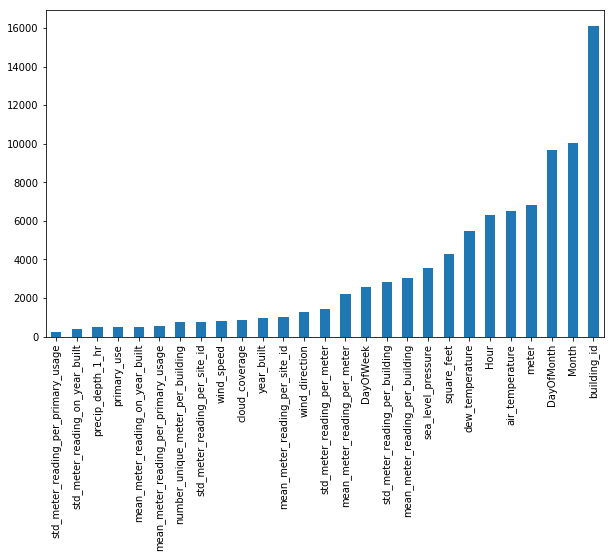

In [35]:
del lgb_train,lgb_test
ser = pd.DataFrame(reg.feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
ser['Importance'].plot(kind='bar',figsize=(10,6))

In [36]:
del train

In [37]:
test.shape

(41697600, 27)

In [38]:
%%time
predictions = []
step = 50000
for i in range(0, len(test), step):
    predictions.extend(np.expm1(reg.predict(test.iloc[i: min(i+step, len(test)), :], num_iteration=reg.best_iteration)))

CPU times: user 3h 45min 39s, sys: 12.6 s, total: 3h 45min 52s
Wall time: 57min 43s


In [39]:
%%time
Submission = pd.DataFrame(test.index,columns=['row_id'])
Submission['meter_reading'] = predictions
Submission['meter_reading'].clip(lower=0,upper=None,inplace=True)
Submission.to_csv("lgbm.csv",index=None)

CPU times: user 4min 25s, sys: 3.12 s, total: 4min 28s
Wall time: 4min 28s


What to ADD : 

In [40]:
#use onehotencoding instead of categorical_feature ? https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html